In [3]:
!pip install shap

In [4]:
import re
import csv

from datetime import datetime
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer

def months_difference(date1, date2):
    '''Calculates the difference in months between two dates.'''
    date1 = re.sub(r"-", "/", date1)
    date2 = re.sub(r"-", "/", date2)
    # Convert string dates to datetime objects
    d1 = datetime.strptime(date1, "%Y/%m/%d")
    d2 = datetime.strptime(date2, "%Y/%m/%d")

    # Calculate the difference in years and months
    year_diff = d2.year - d1.year
    month_diff = d2.month - d1.month

    # Total months difference
    total_months = year_diff * 12 + month_diff

    return total_months


def read_write_data():
    '''Reads the SPARQL output and writes updated data to a file, including the difference in
    months and an accumulation of keywords.
    '''
    # File paths
    input_csv = 'data/trajectory_love.csv'  # Input CSV file path
    output_csv = 'data/data_rep.csv'  # Output CSV file path

    df = pd.read_csv(input_csv)

    # Creates a a updated dataframe aggregated by ID,
    # Makes a set of unique keywords that each ID has.
    grouped_df = (
        df.groupby('id').agg({
            'kudos': 'first',
            'title': 'first',
            'romanticCategory': 'first',
            'rating': 'first',
            'contentWarning': 'first',
            'words': 'first',
            'packaged': 'first',
            'published': 'first',
            'keyword': lambda x: ', '.join(set(x))
        }).reset_index())

    # Counts the amount of keywords for each item in the dataframe.
    grouped_df['amount_keywords'] = grouped_df['keyword'].str.split().str.len()

    # Calculates the uptime for each item in the dataframe
    up_times = []
    for i in range(len(grouped_df)):
        published = grouped_df['published'][i]
        packaged = grouped_df['packaged'][i][:-9]
        up_times.append(months_difference(published, packaged))
    grouped_df['up_time'] = up_times

    # If you want the CSV dataframe as well
    # grouped_df.to_csv(output_csv, index=False)

    return grouped_df


def create_tfidf_data(df):
    '''Creates tfidf columns for keywords, rating, contentWarning and romanticCategory'''
    columns_to_process = ['keyword', 'rating', 'contentWarning', 'romanticCategory']  # Update with your column names

    # Choose the TF-idf vectorizer
    vectorizer = TfidfVectorizer()

    for col in columns_to_process:
        documents = df[col].dropna().tolist()  # Also drops NaN values
        documents = [' '.join(doc.split(',')) for doc in documents]

        # Compute TF-IDF for a column
        tfidf_matrix = vectorizer.fit_transform(documents)

        # Convert the TF-IDF matrix to a DataFrame
        tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

        # Drop rows in the original DataFrame where the column has NaN, to match the TF-IDF result shape
        df_non_na = df[col].dropna().index

        # Overwrite the original column with the sum of the TF-IDF weights per row
        df.loc[df_non_na, col] = tfidf_df.sum(axis=1).values

    # If you want to download the tfidf dataframe
    # df.to_csv('data/tfidf_rep.csv', index=False)

    return df


def main():
    df = read_write_data()
    tfidf_df = create_tfidf_data(df)

    X = df.loc[:, ['words', 'amount_keywords', 'up_time']]
    Z = tfidf_df.loc[:, ['keyword', 'romanticCategory', 'rating', 'contentWarning']]

    X = pd.concat([X, Z], axis=1)
    y = df["kudos"]

    X.to_csv('data/all_X.csv', index=False)
    y.to_csv('data/all_y.csv', index=False)

if __name__ == "__main__":
    main()

In [5]:
import re
import csv

from datetime import datetime
import pandas as pd
import numpy as np
from pandas.io import xml

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split


def months_difference(date1, date2):
    '''Calculates the difference in months between two dates.'''
    date1 = re.sub(r"-", "/", date1)
    date2 = re.sub(r"-", "/", date2)
    # Convert string dates to datetime objects
    d1 = datetime.strptime(date1, "%Y/%m/%d")
    d2 = datetime.strptime(date2, "%Y/%m/%d")

    # Calculate the difference in years and months
    year_diff = d2.year - d1.year
    month_diff = d2.month - d1.month

    # Total months difference
    total_months = year_diff * 12 + month_diff

    return total_months


def read_write_data():
    '''Reads the SPARQL output and writes updated data to a file, including the difference in
    months and an accumulation of keywords.
    '''
    # File paths
    input_csv = 'data/trajectory_love.csv'  # Input CSV file path
    output_csv = 'data/data_rep.csv'  # Output CSV file path

    df = pd.read_csv(input_csv)

    # Creates a a updated dataframe aggregated by ID,
    # Makes a set of unique keywords that each ID has.
    grouped_df = (
        df.groupby('id').agg({
            'kudos': 'first',
            'title': 'first',
            'romanticCategory': 'first',
            'rating': 'first',
            'contentWarning': 'first',
            'words': 'first',
            'packaged': 'first',
            'published': 'first',
            'keyword': lambda x: ', '.join(set(x))
        }).reset_index())

    # Counts the amount of keywords for each item in the dataframe.
    grouped_df['amount_keywords'] = grouped_df['keyword'].str.split().str.len()

    # Calculates the uptime for each item in the dataframe
    up_times = []
    for i in range(len(grouped_df)):
        published = grouped_df['published'][i]
        packaged = grouped_df['packaged'][i][:-9]
        up_times.append(months_difference(published, packaged))
    grouped_df['up_time'] = up_times

    # If you want the CSV dataframe as well
    # grouped_df.to_csv(output_csv, index=False)

    return grouped_df


from gensim.models import Word2Vec

def create_word2vec(df, columns, vector_size=100, window=5, min_count=1):
    '''Takes a list a df and list of columns as input and creates Word2Vec representations for the specified columns'''
    for column in columns:
        tokenized_column = df[column].apply(lambda x: str(x).split())

        model = Word2Vec(sentences=tokenized_column, vector_size=vector_size, window=window, min_count=min_count)

        df[column] = tokenized_column.apply(lambda tokens: model.wv[tokens].mean(axis=0) if tokens else [0] * vector_size)

    return df

def array_to_value(df_transformed):
  '''Takes a df with arrays of number as input and creates mean, max, and min values for the columns specified in the funtion'''

  df_transformed['keywords_mean'] = df_transformed['keyword'].apply(np.mean)
  df_transformed['keywords_max'] = df_transformed['keyword'].apply(np.max)
  df_transformed['keywords_min'] = df_transformed['keyword'].apply(np.min)

  df_transformed['rating_mean'] = df_transformed['rating'].apply(np.mean)
  df_transformed['rating_max'] = df_transformed['rating'].apply(np.max)
  df_transformed['rating_min'] = df_transformed['rating'].apply(np.min)

  df_transformed['contentWarning_mean'] = df_transformed['contentWarning'].apply(np.mean)
  df_transformed['contentWarning_max'] = df_transformed['contentWarning'].apply(np.max)
  df_transformed['contentWarning_min'] = df_transformed['contentWarning'].apply(np.min)

  df_transformed['romanticCategory_mean'] = df_transformed['romanticCategory'].apply(np.mean)
  df_transformed['romanticCategory_max'] = df_transformed['romanticCategory'].apply(np.max)
  df_transformed['romanticCategory_min'] = df_transformed['romanticCategory'].apply(np.min)

  df_transformed = df_transformed.iloc[:, 12:]

  return df_transformed

def main():
    df = read_write_data()
    columns_to_transform = ['keyword', 'rating', 'contentWarning', 'romanticCategory']
    df_wTv = create_word2vec(df, columns_to_transform)
    df_wTv = array_to_value(df_wTv)

    X = df.loc[:, ['words', 'amount_keywords', 'up_time']]
    Z = df_wTv

    X = pd.concat([X, Z], axis=1)
    y = df["kudos"]

    X.to_csv('data/all_X_wTv.csv', index=False)
    y.to_csv('data/all_y_wTv.csv', index=False)

if __name__ == "__main__":
    main()


 Model used: lr 



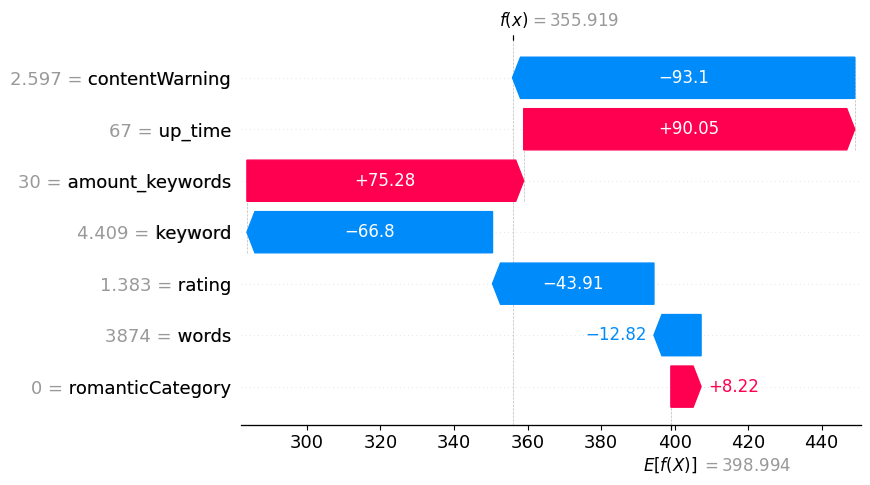

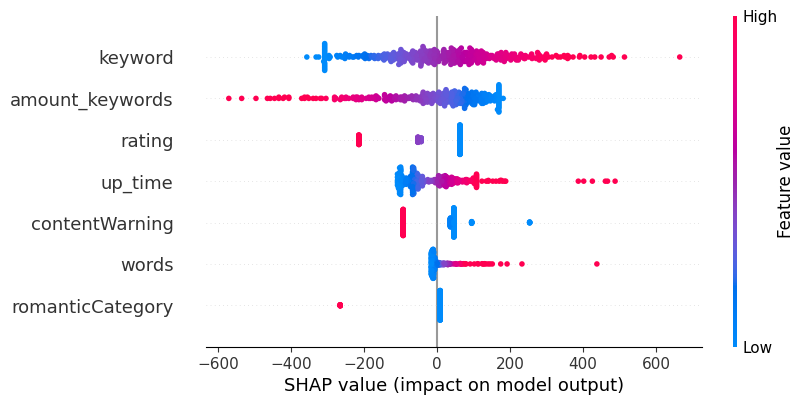


 Model used: dt 



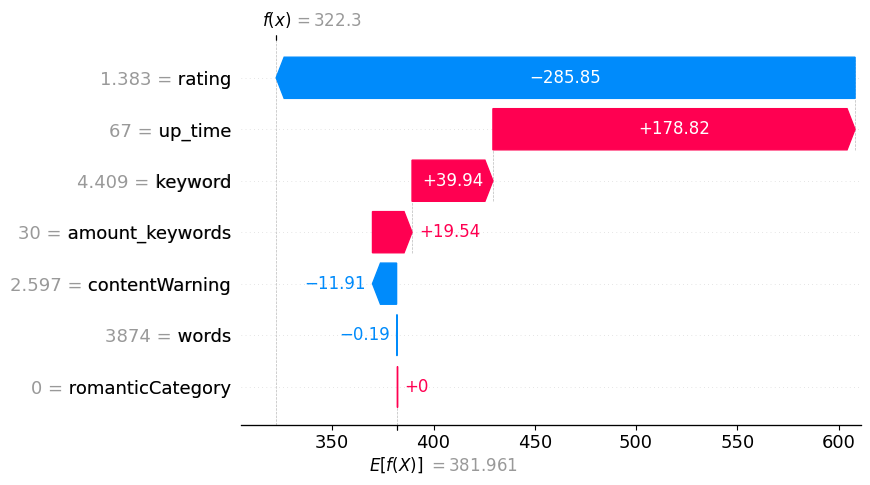

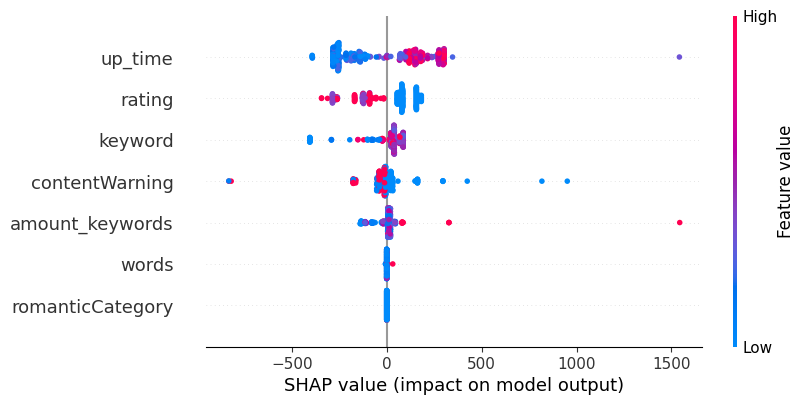

ExactExplainer explainer: 365it [00:18,  8.03it/s]                         



 Model used: rf 



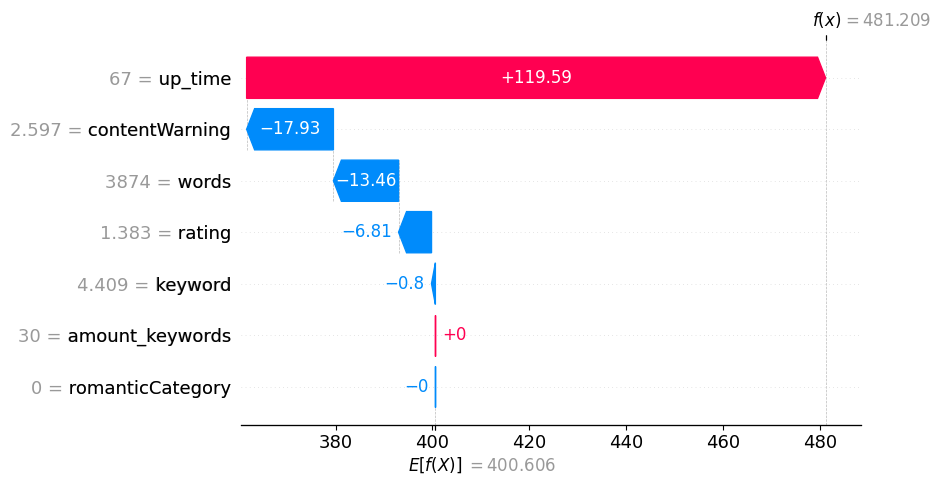

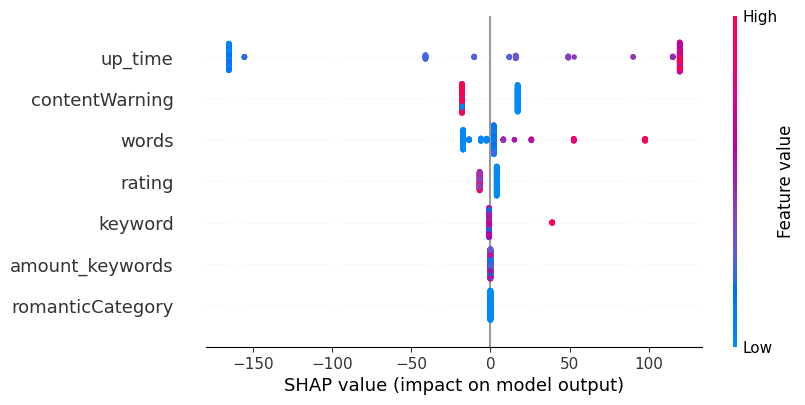


 Model used: svrl 



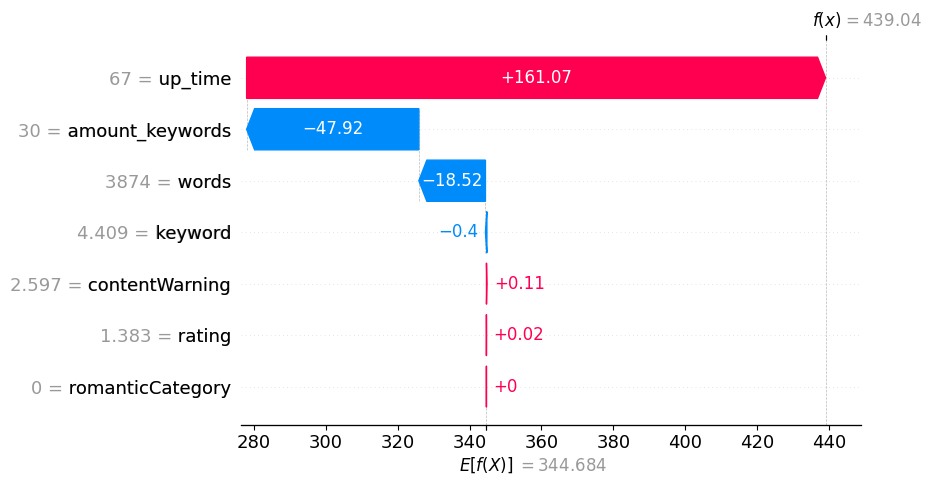

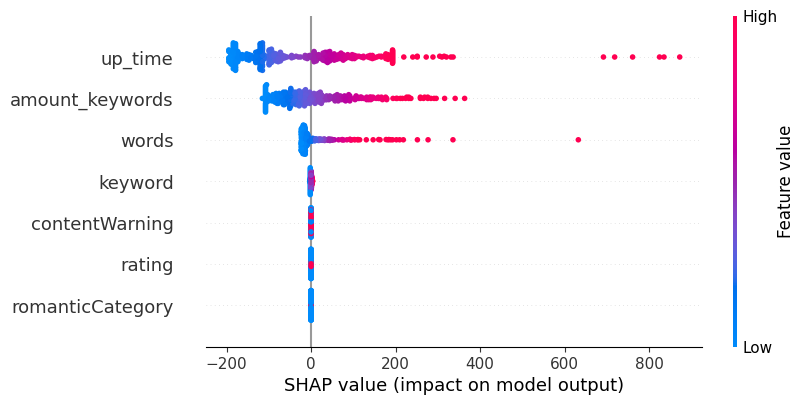

In [6]:
import shap
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR, LinearSVR
from sklearn.preprocessing import StandardScaler

def choose_model(algorithm):
    '''Chooses the model based on the given arguments.
    Returns the model with hyperparameters.
    '''
    # The Decision Trees model
    if algorithm == 'dt':
        model = DecisionTreeRegressor(random_state=42, max_depth=4, splitter="random")

    # The Random Forest model
    elif algorithm == 'rf':
        model = RandomForestRegressor(random_state=42, n_estimators=100, max_depth=1)

    # The Linear Regression model
    elif algorithm == "lr":
        model = LinearRegression()

    # The SVR model
    elif algorithm == "svr":
        model = SVR(kernel="linear", C=12)

    # The Linear SVR model
    elif algorithm == "svrl":
        model = LinearSVR(random_state=42, loss="squared_epsilon_insensitive")

    return model

def main():
    # List of models to train
    algorithms = ["lr", "dt", "rf", "svrl"]

    X = pd.read_csv("data/all_X.csv")
    y = pd.read_csv("data/all_y.csv")
    y = y["kudos"]

    X100 = shap.utils.sample(X, 100)

    # Train each model and analyze with SHAP
    for algorithm in algorithms:
        model = choose_model(algorithm)
        model.fit(X, y)

        #print("Model coefficients:\n")
        #for i in range(X.shape[1]):
        #    print(X.columns[i], "=", model.coef_[i].round(5))

        explainer = shap.Explainer(model.predict, X100)
        shap_values = explainer(X)

        print("\n Model used:",algorithm,"\n")

        sample_ind = 20
        shap.plots.waterfall(shap_values[sample_ind], max_display=8)
        shap.plots.beeswarm(shap_values)

if __name__ == "__main__":
    main()


In [ ]:
import shap
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR, LinearSVR
from sklearn.preprocessing import StandardScaler

def choose_model(algorithm):
    '''Chooses the model based on the given arguments.
    Returns the model with hyperparameters.
    '''
    # The Decision Trees model
    if algorithm == 'dt':
        model = DecisionTreeRegressor(random_state=42, max_depth=4, splitter="random")

    # The Random Forest model
    elif algorithm == 'rf':
        model = RandomForestRegressor(random_state=42, n_estimators=100, max_depth=1)

    # The Linear Regression model
    elif algorithm == "lr":
        model = LinearRegression()

    # The SVR model
    elif algorithm == "svr":
        model = SVR(kernel="linear", C=12)

    # The Linear SVR model
    elif algorithm == "svrl":
        model = LinearSVR(random_state=42, loss="squared_epsilon_insensitive")

    return model

def main():
    # List of models to train
    algorithms = ["svr"]

    X = pd.read_csv("data/all_X.csv")
    y = pd.read_csv("data/all_y.csv")
    y = y["kudos"]

    X100 = shap.utils.sample(X, 100)

    # Train each model and analyze with SHAP
    for algorithm in algorithms:
        model = choose_model(algorithm)
        model.fit(X, y)

        #print("Model coefficients:\n")
        #for i in range(X.shape[1]):
        #    print(X.columns[i], "=", model.coef_[i].round(5))

        explainer = shap.Explainer(model.predict, X100)
        shap_values = explainer(X)

        print("\n Model used:",algorithm,"\n")

        sample_ind = 20
        shap.plots.waterfall(shap_values[sample_ind], max_display=8)
        shap.plots.beeswarm(shap_values)

if __name__ == "__main__":
    main()


PermutationExplainer explainer: 365it [00:34,  7.62it/s]                         



 Model used: lr 



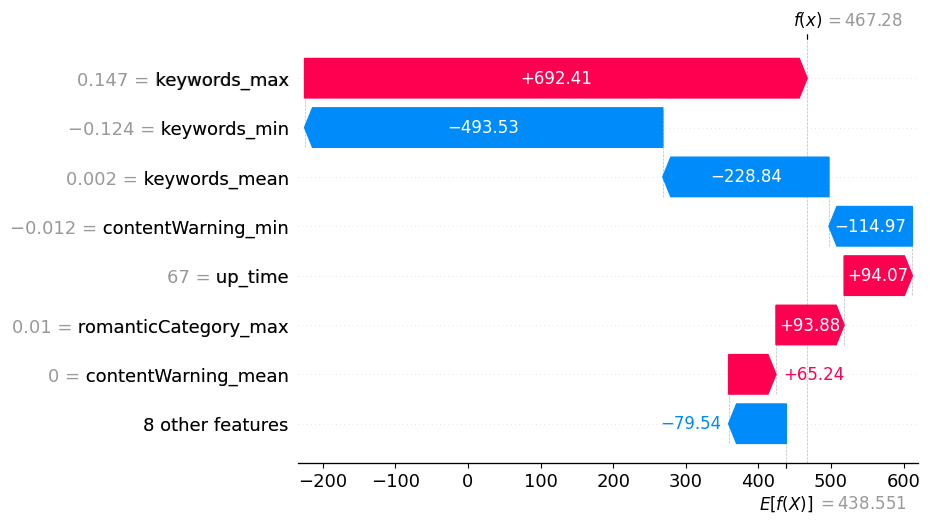

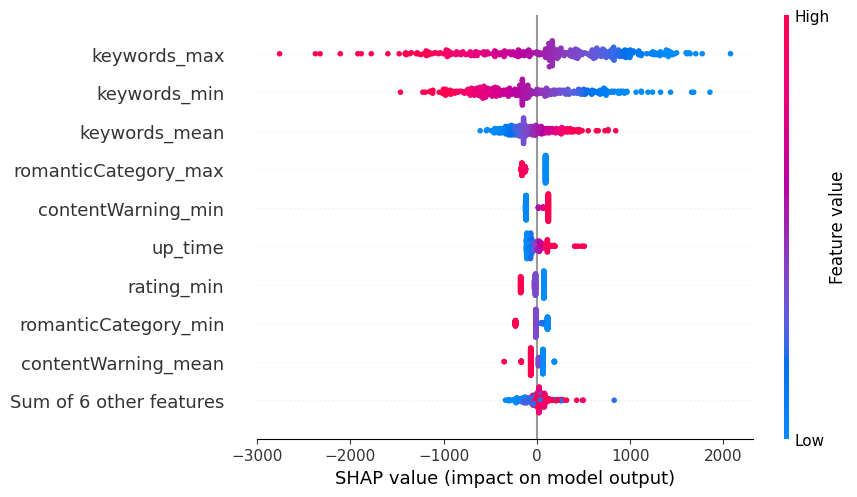

PermutationExplainer explainer: 365it [00:11,  4.65it/s]



 Model used: dt 



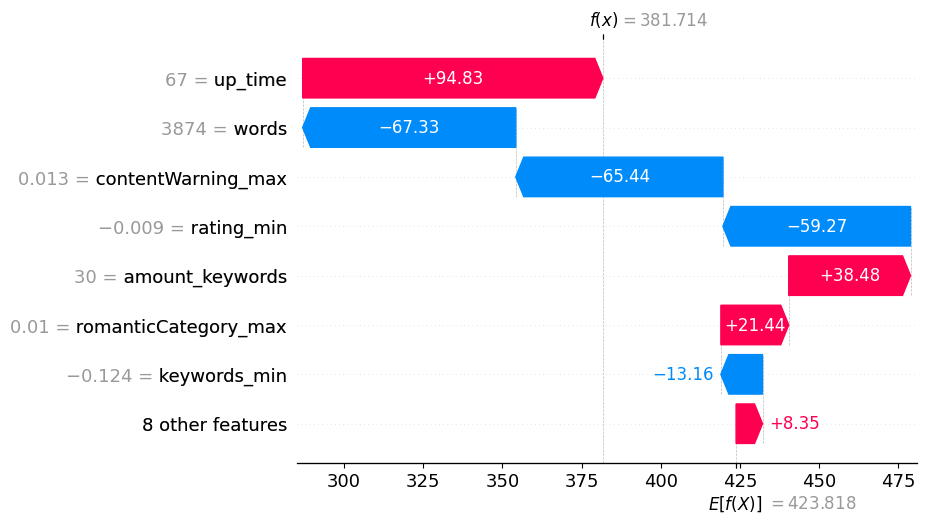

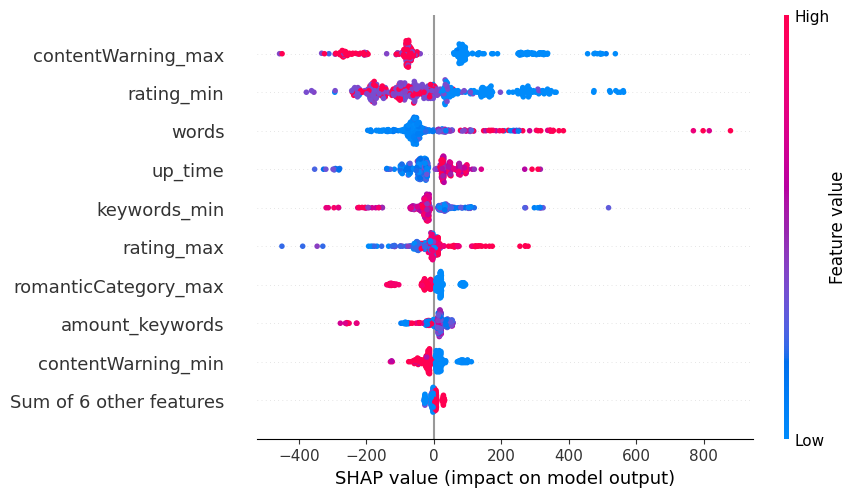

In [ ]:
import shap
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR, LinearSVR
from sklearn.preprocessing import StandardScaler

def choose_model(algorithm):
    '''Chooses the model based on the given arguments.
    Returns the model with hyperparameters.
    '''
    # The Decision Trees model
    if algorithm == 'dt':
        model = DecisionTreeRegressor(random_state=42, max_depth=4, splitter="random")

    # The Random Forest model
    elif algorithm == 'rf':
        model = RandomForestRegressor(random_state=42, n_estimators=100, max_depth=1)

    # The Linear Regression model
    elif algorithm == "lr":
        model = LinearRegression()

    # The SVR model
    elif algorithm == "svr":
        model = SVR(kernel="linear", C=12)

    # The Linear SVR model
    elif algorithm == "svrl":
        model = LinearSVR(random_state=42, loss="squared_epsilon_insensitive")

    return model

def main():
    # List of models to train
    algorithms = ["lr", "dt", "rf", "svrl"]

    X = pd.read_csv("data/all_X_wTv.csv")
    y = pd.read_csv("data/all_y_wTv.csv")
    y = y["kudos"]

    X100 = shap.utils.sample(X, 100)

    # Train each model and analyze with SHAP
    for algorithm in algorithms:
        model = choose_model(algorithm)
        model.fit(X, y)

        #print("Model coefficients:\n")
        #for i in range(X.shape[1]):
        #    print(X.columns[i], "=", model.coef_[i].round(5))

        explainer = shap.Explainer(model.predict, X100)
        shap_values = explainer(X)

        print("\n Model used:",algorithm,"\n")

        sample_ind = 20
        shap.plots.waterfall(shap_values[sample_ind], max_display=8)
        shap.plots.beeswarm(shap_values)

if __name__ == "__main__":
    main()


In [ ]:
import shap
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR, LinearSVR
from sklearn.preprocessing import StandardScaler

def choose_model(algorithm):
    '''Chooses the model based on the given arguments.
    Returns the model with hyperparameters.
    '''
    # The Decision Trees model
    if algorithm == 'dt':
        model = DecisionTreeRegressor(random_state=42, max_depth=4, splitter="random")

    # The Random Forest model
    elif algorithm == 'rf':
        model = RandomForestRegressor(random_state=42, n_estimators=100, max_depth=1)

    # The Linear Regression model
    elif algorithm == "lr":
        model = LinearRegression()

    # The SVR model
    elif algorithm == "svr":
        model = SVR(kernel="linear", C=12)

    # The Linear SVR model
    elif algorithm == "svrl":
        model = LinearSVR(random_state=42, loss="squared_epsilon_insensitive")

    return model

def main():
    # List of models to train
    algorithms = ["svr"]

    X = pd.read_csv("data/all_X_wTv.csv")
    y = pd.read_csv("data/all_y_wTv.csv")
    y = y["kudos"]

    X100 = shap.utils.sample(X, 100)

    # Train each model and analyze with SHAP
    for algorithm in algorithms:
        model = choose_model(algorithm)
        model.fit(X, y)

        #print("Model coefficients:\n")
        #for i in range(X.shape[1]):
        #    print(X.columns[i], "=", model.coef_[i].round(5))

        explainer = shap.Explainer(model.predict, X100)
        shap_values = explainer(X)

        print("\n Model used:",algorithm,"\n")

        sample_ind = 20
        shap.plots.waterfall(shap_values[sample_ind], max_display=8)
        shap.plots.beeswarm(shap_values)

if __name__ == "__main__":
    main()
